In [ ]:
!pip install torch
!pip install -q transformers gradio accelerate -U

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
!pip install -q Cython torch

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from transformers import (RobertaTokenizer,
                          RobertaForSequenceClassification,
                          Trainer,
                          TrainingArguments)

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             precision_recall_fscore_support,
                             confusion_matrix)
import gradio as gr

In [ ]:
##https://drive.google.com/file/d/1hpJjuyvXD_iHybmQ_F-WZ4W1oGidHZEy/view?usp=drive_link
##https://drive.google.com/file/d/17Um12qRGVwCbDA-TLcUDAkymYssNsN2T/view?usp=drive_link
!gdown 17Um12qRGVwCbDA-TLcUDAkymYssNsN2T

Downloading...
From: https://drive.google.com/uc?id=17Um12qRGVwCbDA-TLcUDAkymYssNsN2T
To: /content/FinalRatingsOver.csv
100% 3.08M/3.08M [00:00<00:00, 259MB/s]


In [ ]:
df = pd.read_csv("FinalRatingsOver.csv")
df

,review,label
0,outlet great better dish servic yum garlic amb...,1
1,summer pay qualiti tax get realli time visit s...,0
2,varieti toastizza differ theyv burger mark the...,1
3,blue recommend cool sizzl qualiti could dazzl ...,1
4,dri realli stale month small meet unfortun pla...,1
...,...,...
20597,cannot guarante fli ever food charg inspect it...,0
20598,anyon qualiti cardboard pizza place NUM drop N...,0
20599,concern rais experi repeatedli dine place sing...,0
20600,NUM blue locat chai sky rate stock know strang...,0


In [ ]:
df["label"].value_counts()

label
1    10301
0    10301
Name: count, dtype: int64

In [ ]:
X = df['review']
y = df['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
class RVDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
# Tokenize the data
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True)

# Create datasets
train_dataset = RVDataset(train_encodings, y_train.tolist())
test_dataset = RVDataset(test_encodings, y_test.tolist())

# Load pre-trained model
model = RobertaForSequenceClassification.from_pretrained('roberta-base')

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=150,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.358600
1000,0.211600
1500,0.138800
2000,0.090500
2500,0.056100


TrainOutput(global_step=2580, training_loss=0.16770596411801122, metrics={'train_runtime': 2589.8634, 'train_samples_per_second': 31.818, 'train_steps_per_second': 0.996, 'total_flos': 8342359968432300.0, 'train_loss': 0.16770596411801122, 'epoch': 5.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.19787795841693878,
 'eval_runtime': 32.4998,
 'eval_samples_per_second': 126.801,
 'eval_steps_per_second': 3.969,
 'epoch': 5.0}

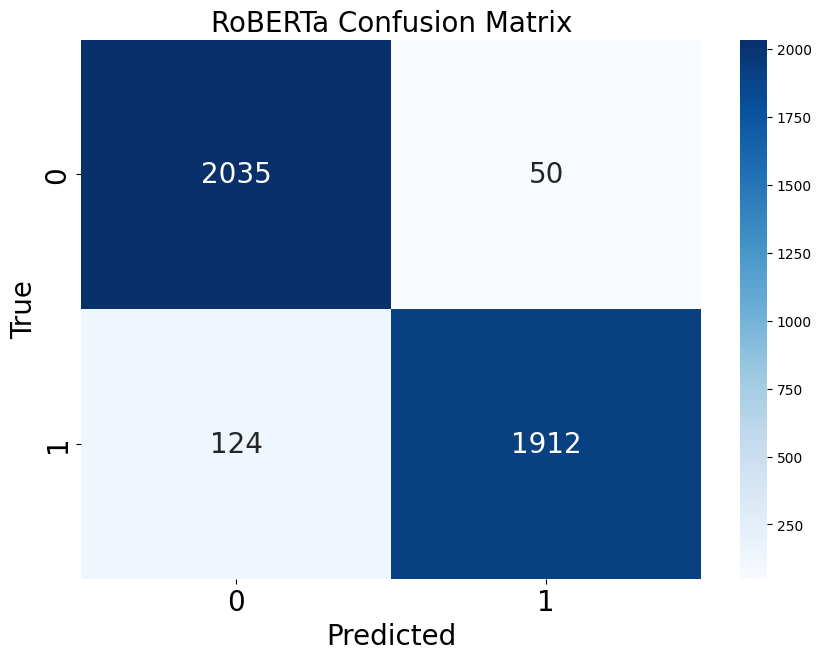

In [ ]:

def evaluate(model, tokenizer, X, y, device, batch_size=32):
    model.to(device)
    model.eval()

    accuracies, precisions, recalls, f1s = [], [], [], []
    all_predictions, all_true_labels = [], []

    for i in range(0, len(X), batch_size):
        batch_X = X[i:i + batch_size]
        batch_y = y[i:i + batch_size]

        inputs = tokenizer(batch_X.tolist(), padding=True, truncation=True, return_tensors="pt").to(device)
        labels = torch.tensor(batch_y.tolist()).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=-1)
            precision, recall, f1, _ = precision_recall_fscore_support(labels.cpu(), predictions.cpu(), average='binary')
            accuracy = accuracy_score(labels.cpu(), predictions.cpu())

            accuracies.append(accuracy)
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)

            all_predictions.extend(predictions.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    # Calculate average metrics
    avg_accuracy = sum(accuracies) / len(accuracies)
    avg_precision = sum(precisions) / len(precisions)
    avg_recall = sum(recalls) / len(recalls)
    avg_f1 = sum(f1s) / len(f1s)

    # Plotting the confusion matrix
    cm = confusion_matrix(all_true_labels, all_predictions)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            annot_kws={"size": 20})
    plt.xlabel('Predicted', fontsize=20)
    plt.ylabel('True', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title('RoBERTa Confusion Matrix', fontsize=20)
    plt.savefig('RoBERTa Confusion Matrix.pdf')
    plt.show()

    return avg_accuracy, avg_precision, avg_recall, avg_f1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
acc, precision, recall, f1 = evaluate(model, tokenizer, X_test, y_test, device, batch_size=32)


In [ ]:

print(f"Accuracy: \t {acc:.2f}")
print(f"Precision: \t {precision:.2f}")
print(f"Recall: \t {recall:.2f}")
print(f"F1 Score: \t {f1:.2f}")

Accuracy: 	 0.96
Precision: 	 0.97
Recall: 	 0.94
F1 Score: 	 0.96


In [ ]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:

torch.save(model.state_dict(), 'model_checkpoint.pth')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/ICT- NQH/End Term/RoBERTa/model'

In [ ]:
model.save_pretrained(path)